In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.hnc import Integral_Equation_Solver as IET
from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n

from pandas import read_csv
from scipy.fft import fft, ifft, fftshift, ifftshift, dct, dst
import tt as ttpy

from liquids.python.qtt_core.qtt_util import *

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")

# import 

In [2]:
Γ, κ = 100, 2
N_bits = 12
iet = IET(1, [[Γ]], [[3/(4*π)]], [[1]], [1], kappa = κ, dst_type=4, N_bins = 2**N_bits, R_max = 100)
iet.HNC_solve(tol=1e-10, num_iterations=1e5, iters_to_wait=1e4)
h_r_array = iet.h_r_matrix[0,0]
# h_r_array = np.exp(-(iet.r_array-40)**2/(2*1**2)) #iet.h_r_matrix[0,0]


0: Initial condition Total Error: 1.325e+00
Exiting status 0, reverting to best index so far: 2564
Final iter:2565, Total Error: 9.942e-11


In [3]:
def dct_type1(x):
    """
    Pure-polynomial DCT-I (no special sqrt scaling).
    """
    N = len(x)

    # 1) build the extended array of length 2*(N-1)
    #    [ x[0], x[1], ..., x[N-2], x[N-1], x[N-2], ..., x[1] ]
    M = 2*(N-1)
    x_ext = np.zeros(M, dtype=complex)
    x_ext[:N] = x
    x_ext[N:M] = x[-2:0:-1]  # reversed from x[N-2] down to x[1]

    # 2) take DFT
    X_ext = fft(x_ext)

    # 3) the standard DCT-I is basically the real part of
    #    (X_ext[k] + X_ext[M - k]) / 2, for k=0..N-1
    #    but if you look carefully, for k=0..N-1:
    #        X_ext[M - k] = X_ext[2N-2 - k].
    #    We can just do the "average" in code. Often it's enough to take X_ext[k].real,
    #    or do 0.5 * (X_ext[k] + conj(X_ext[M-k])) if you want guaranteed real.
    
    # We'll form the length-N result:
    X = 0.5 * (X_ext[:N] + np.conjugate(X_ext[M : M - N : -1]))
    return X.real

def dct_type4(x):
    """
    Pure-polynomial DCT-IV (no extra sqrt scaling).
    """
    N = len(x)
    n = np.arange(N)

    # pre-twiddle for half-integer shift in time
    pre_twiddle = np.exp(-1j * np.pi * (n + 0.5) / (2*N))
    x_ext = np.zeros(2*N, dtype=complex)
    x_ext[:N] = x * pre_twiddle

    X_ext = fft(x_ext)

    # post-twiddle for half-integer shift in frequency
    post_twiddle = np.exp(-1j * np.pi * (n + 0.5) / (2*N))
    return 2.0 * (X_ext[:N] * post_twiddle).real

def dct_type2(vec_r):
    N = len(vec_r)
    vec_r_ext = np.zeros(2*N)
    vec_r_ext[:N] = vec_r
    return 2*(fft(vec_r_ext)[:N]*np.exp(-1j*np.arange(N)*π/2/N)).real


In [4]:

def dst_type4(vec_r):
    N = len(vec_r)
    n_array = np.arange(N) 
    vec_r_ext = np.zeros(2*N)
    vec_r_ext[:N] = vec_r*np.exp(-1j*π*n_array/2/N)
    return -2*(fft(vec_r_ext)[:N]*np.exp(-1j*(n_array + 1/2)*π/2/N)).imag


In [5]:
h_dst3 = dst(h_r_array, type=3)
h_dst4 = dst(h_r_array, type=4)

# h_dst3_attempt = dst_type3(h_r_matrix[0,0])
h_dst4_attempt = dst_type4(h_r_array)


/tmp/ipykernel_60955/4002906795.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  vec_r_ext[:N] = vec_r*np.exp(-1j*π*n_array/2/N)


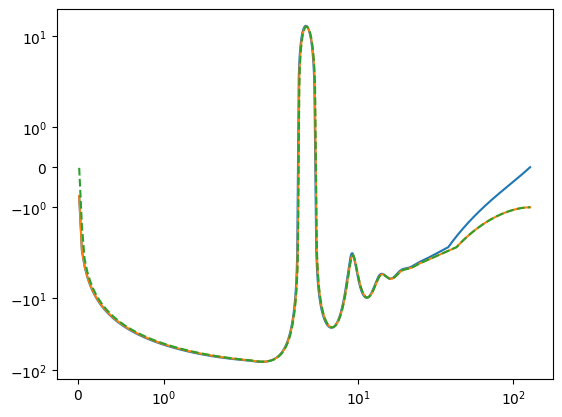

In [6]:
fig, ax = plt.subplots()

ax.plot(iet.k_array, h_dst3)
ax.plot(iet.k_array, h_dst4)
# ax.plot(iet.k_array, h_dst3_attempt, '--')
ax.plot(iet.k_array, h_dst4_attempt, '--')


# ax.plot(iet.k_array, βu_dct4) 
# ax.plot(iet.k_array, βu_dct4_attempt) 

# ax.plot(iet.k_array, βu_dct2) 
# ax.plot(iet.k_array, βu_dct2_attempt) 
ax.set_yscale('symlog')
ax.set_xscale('symlog')

### QTT Tests on Converged Sims

In [7]:
βu_r_array = iet.βu_k_matrix[0,0]
βu_r_bt = tensor_to_binarytensor(βu_r_array, order='F')
βu_r_qtt = ttpy.vector(βu_r_bt, eps=1e-4)

# h_r_array = np.exp(-(iet.r_array-40)**2/(2*1**2)) #iet.h_r_matrix[0,0]
# h_r_array = h_r_matrix[0,0]
h_r_bt = tensor_to_binarytensor(h_r_array, order='F')
h_r_qtt = ttpy.vector(h_r_bt, eps=1e-12)

c_r_array = iet.c_k_matrix[0,0]
c_r_bt = tensor_to_binarytensor(c_r_array, order='F')
c_r_qtt = ttpy.vector(c_r_bt, eps=1e-4)

γs_r_array = iet.γs_r_matrix[0,0]
γs_r_bt = tensor_to_binarytensor(γs_r_array, order='F')
γs_r_qtt = ttpy.vector(γs_r_bt, eps=1e-4)

In [8]:
get_bigtable(βu_r_array, βu_r_bt, np.nan, βu_r_qtt, [0,0,0,0])
get_bigtable(h_r_array, h_r_bt, np.nan, h_r_qtt, [0,0,0,0])
get_bigtable(c_r_array, c_r_bt, np.nan, c_r_qtt, [0,0,0,0])
get_bigtable(γs_r_array, γs_r_bt, np.nan, γs_r_qtt, [0,0,0,0])

╒═════════════════════════════╤═══════════════════════════════╤═════════════════════════╤═══════════════════════════════╕
│                             │                               │                         │                               │
├─────────────────────────────┼───────────────────────────────┼─────────────────────────┼───────────────────────────────┤
│                             │ Grid                          │ TT                      │ QTT                           │
├─────────────────────────────┼───────────────────────────────┼─────────────────────────┼───────────────────────────────┤
│ Error (|F1-F2|/|F1|)        │ 0                             │ nan                     │ 1.771e-05                     │
├─────────────────────────────┼───────────────────────────────┼─────────────────────────┼───────────────────────────────┤
│ Memory (of Square)          │ 0.0328 MB (0.0328 MB)         │ nan MB (nan MB)         │ 0.0021 MB (0.0277 MB)         │
├───────────────────────

[[''],
 ['', 'Grid', 'TT', 'QTT'],
 ['Error (|F1-F2|/|F1|)', 0, 'nan', '1.229e-05'],
 ['Memory (of Square)',
  '0.0328 MB (0.0328 MB)',
  'nan MB (nan MB)',
  '0.0011 MB (0.0113 MB)'],
 ['Compression (of Square)', 1, 'nan (nan)', '29.681 (2.889)'],
 ['Creation time (Square time)',
  '0.000e+00 [s] (9.060e-06 [s])',
  '0.000e+00 [s] (nan [s])',
  '0.000e+00 [s] (1.490e-04 [s])']]

In [9]:
2**N_bits

4096

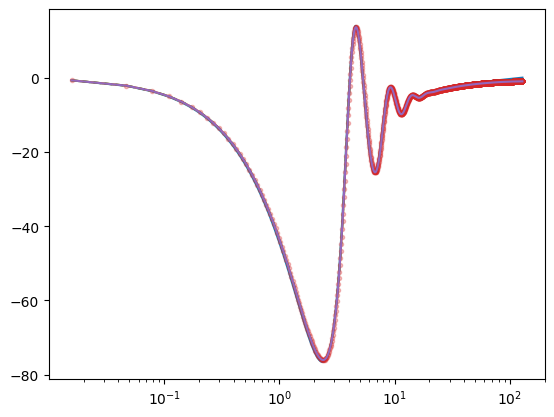

In [23]:
def dst_type4(vec_r):
    N = len(vec_r)
    n_array = np.arange(N) 
    vec_r_ext = np.zeros(2*N)
    first_phase_shift = np.exp(-1j*π*n_array/2/N)
    vec_r_ext[:N] = vec_r*first_phase_shift
    second_phase_shift = np.exp(-1j*(n_array + 1/2)*π/2/N)
    # return vec_r_ext
    # return fft(vec_r_ext)[:N]
    # return second_phase_shift
    # return fft(vec_r_ext)[:N]*second_phase_shift
    return -2*(fft(vec_r_ext)[:N]*np.exp(-1j*(n_array + 1/2)*π/2/N)).imag

def dst_type4_qtt(qtt_r, eps=1e-6, inverse=False): # ONLY WORKS WITH F ORDERING
    N_bits = qtt_r.d
    N_grid = 2**N_bits
    n_array = np.arange(N_grid) 
    
    # Phase shift in r-space
    qtt_first_phase_shift = ttpy.vector(tensor_to_binarytensor(np.exp(-1j*π*n_array/2/N_grid), order='F'))
    qtt_r = (qtt_r*qtt_first_phase_shift).round(eps)
    
    # Extend by filling new half of space with zeros
    qtt_r_extended = ttpy.vector.from_list( qtt_r.to_list(qtt_r) + [ np.array([1,0]).reshape(1,2,1, order='F') ])
    
    # Do FFT (Assumes F ordering! )
    qtt_r_extended_fft = qtt_r_extended.qtt_fft1(tol=eps)*np.sqrt(2**(N_bits+1))
    qtt_r_extended_fft_cores = qtt_r_extended_fft.to_list(qtt_r_extended_fft)
    
    # Now take only first half of k-space, needing a core multiplication here 
    qtt_r_extended_fft_cores[-2] = qtt_r_extended_fft_cores[-2].dot(qtt_r_extended_fft_cores[-1][:,0,0])[:,:,np.newaxis]
    qtt_r_fft = ttpy.vector.from_list(qtt_r_extended_fft_cores[:-1]).round(eps) # remove first, gone, core
    
    # Now second phase shift 
    qtt_second_phase_shift = ttpy.vector(tensor_to_binarytensor(np.exp(-1j*(n_array+0.5)*π/2/N_grid), order='F'))
    qtt_k_fft = (qtt_r_fft*qtt_second_phase_shift).round(eps)
    qtt_k = -2*(qtt_k_fft.imag())
    if not inverse:
        return qtt_k
    else:
        return 0.5/N_grid * qtt_k

# tmp1 = dst_type4_qtt(h_r_qtt, 1e-3) 
# tmp2 = dst_type4(h_r_array)

# tmp1 = qtt_fft1(h_r_qtt, 1e-6)
# tmp2 = fft(h_r_array)


fig,ax = plt.subplots()
   
# ax.plot(100*fftshift(tmp1.full().reshape(2*2**N_bits, order='F')))
# ax.plot(fftshift(tmp2), '--',alpha=0.4)


# ax.plot(iet.k_array, tmp2, '--',alpha=0.4)

ax.plot(iet.k_array, h_dst3)
ax.plot(iet.k_array, dst(h_r_array, type=4))
ax.plot(iet.k_array, h_dst4, '--')

# ax.plot(iet.k_array, h_dst4_attempt, '--')
ax.plot(iet.k_array, binarytensor_to_tensor(dst_type4_qtt(h_r_qtt,eps=1e-12).full(), order='F' ) ,'--.',alpha=0.3)
ax.plot(iet.k_array, binarytensor_to_tensor(dst4_qtt(h_r_qtt,eps=1e-12).full(), order='F' ) ,'-',alpha=1)

# ax.plot(iet.r_array, h_r_array)
# ax.plot(iet.r_array, 0.5/2**N_bits*dst_type4(dst_type4(h_r_array)))
# ax.plot(iet.r_array, 0.5/2**N_bits*binarytensor_to_tensor(dst_type4_qtt(dst_type4_qtt(h_r_qtt)).full(),order='F') )
# ax.plot(iet.r_array, 0.5/2**N_bits*dst(dst(h_r_array,type=4),type=4))

# ax.plot(iet.k_array, 90*binarytensor_to_tensor(tmp1.full(), order='F')) # MATLAB is F, why does C work here?????
# ax.plot(iet.k_array, tmp2, '--', alpha=0.5)

# h_k_qtt = dst_type4_qt(h_r_qtt) 
# ax.set_xlim(1e3,1e4)
# ax.set_yscale('symlog')
ax.set_xscale('log')

In [11]:
N_bits, 2**N_bits, get_tt_compression(dst_type4_qtt(c_r_qtt, 1e-3) )

(12, 4096, 4.452173913043478)

In [12]:
%%time
dst(c_r_array, type=4)

CPU times: user 717 µs, sys: 110 µs, total: 827 µs
Wall time: 618 µs


array([-179.93439594, -539.5103095 , -898.20891637, ..., -169.02471097,
       -169.02466123, -169.02463637])

In [13]:
%%time
dst_type4(c_r_array)

CPU times: user 3.13 ms, sys: 0 ns, total: 3.13 ms
Wall time: 3.7 ms


/tmp/ipykernel_60955/3687742123.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  vec_r_ext[:N] = vec_r*first_phase_shift


array([  -3.01674253, -362.73908202, -721.87386947, ..., -169.02474206,
       -169.02467989, -169.02464258])

In [14]:
%%time
dst_type4_qtt(γs_r_qtt, 1e-6) 


CPU times: user 39.8 ms, sys: 0 ns, total: 39.8 ms
Wall time: 39.1 ms


This is a 12-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=4, n(1)=2 
r(2)=6, n(2)=2 
r(3)=8, n(3)=2 
r(4)=10, n(4)=2 
r(5)=12, n(5)=2 
r(6)=12, n(6)=2 
r(7)=12, n(7)=2 
r(8)=14, n(8)=2 
r(9)=14, n(9)=2 
r(10)=8, n(10)=2 
r(11)=4, n(11)=2 
r(12)=1 

NameError: name 'h_k_qtt' is not defined

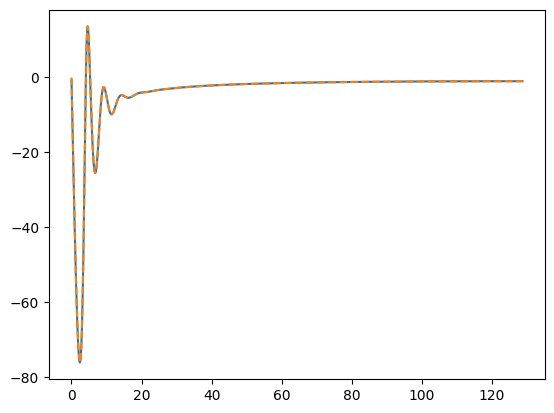

In [15]:
fig, ax = plt.subplots()

# ax.plot(iet.k_array, h_dst3)
ax.plot(iet.k_array, h_dst4)
# ax.plot(iet.k_array, h_dst3_attempt, '--')
ax.plot(iet.k_array, h_dst4_attempt, '--')
ax.plot(iet.k_array, h_k_qtt.full().reshape(2**N_bits, order='C'))
# ax.plot(iet.k_array, 2.8*dst_type4_qtt(h_r_qtt).full().reshape(2**N_bits, order='F'),'k--')
ax.set_yscale('symlog')
ax.set_xscale('symlog')

In [ ]:
h_r_qtt_cores = h_r_qtt.to_list(h_r_qtt)
[core.shape for core in h_r_qtt_cores]
h_r_qtt_extended = ttpy.vector.from_list( [ np.array([1,0]).reshape(1,2,1) ] + h_r_qtt_cores)

fig, ax = plt.subplots()

ax.plot(binarytensor_to_tensor(h_r_qtt_extended.full()))
ax.plot(binarytensor_to_tensor(h_r_qtt.full()),'--')

In [ ]:
h_fft_qtt = h_r_qtt.qtt_fft1(1e-12)
# h_fft_qtt = qtt_fft1(h_r_qtt, 1e-4)
# h_fft_ifft_qtt = h_fft_qtt.qtt_fft1(1e-4, inverse=True)
binarytensor_to_tensor(h_fft_qtt.full())

In [ ]:
h_fft_qtt = h_r_qtt.qtt_fft1(1e-12)
# h_fft_qtt = qtt_fft1(h_r_qtt, 1e-4)
# h_fft_ifft_qtt = h_fft_qtt.qtt_fft1(1e-4, inverse=True)
binarytensor_to_tensor(h_fft_qtt.full())

fig, ax = plt.subplots()

# ax.plot(iet.k_array, 120*binarytensor_to_tensor(h_fft_qtt.full()))
ax.plot(iet.k_array, fftshift(fft(h_r_array)))

ax.set_yscale('symlog')
ax.set_xscale('symlog')
ax.set_xlim(60, 70)

In [ ]:
fig, ax = plt.subplots()

ax.plot(iet.r_array, binarytensor_to_tensor(h_r_qtt.full()))
ax.plot(iet.r_array, binarytensor_to_tensor(h_fft_ifft_qtt.full()))
ax.plot(iet.r_array, h_r_array)

ax.set_yscale('symlog')
ax.set_xscale('symlog')

In [ ]:
iet.plot_g_all_species()

In [ ]:
get_bigtable(βu_r_array, βu_r_bt, np.nan, βu_r_qtt, [0,0,0,0])
get_bigtable(h_r_array, h_r_bt, np.nan, h_r_qtt, [0,0,0,0])
get_bigtable(c_r_array, c_r_bt, np.nan, c_r_qtt, [0,0,0,0])

In [ ]:
qtt_fft1(h_r_qtt, 1e-4)

In [ ]:

Γ, κ = 100, 3
N_bits = 8
r_array = np.linspace(0,100, 2**N_bits)
h_r_array = np.exp(-(r_array-50)**2/(2*1**2))
# h_r_bt = tensor_to_binarytensor(h_r_array)
h_r_bt = h_r_array.reshape(2,2,2,2,2,2,2,2, order='F')
h_r_qtt = ttpy.vector(h_r_bt, eps=1e-12)
h_r_bt
h_fft_qtt = qtt_fft1(h_r_qtt, 1e-8)
def print_like_matlab(tensor):
    for i in range(tensor.shape[-1]):
        print(f"tensor(:,:{i+1})", tensor[:,:,i])
# print_like_matlab(h_r_bt)
print("\nfinal output:")
print_like_matlab(h_fft_qtt.to_list(h_fft_qtt)[1])

In [ ]:
# h_fft_qtt = h_r_qtt.qtt_fft1(1e-12)
h_fft_qtt = qtt_fft1(h_r_qtt, 1e-8)
# h_fft_ifft_qtt = h_fft_qtt.qtt_fft1(1e-4, inverse=True)
h_fft_qtt.full().reshape(2**N_bits, order='F')

fig, ax = plt.subplots()

# ax.plot(r_array, fftshift(binarytensor_to_tensor(h_fft_qtt.full())))
# ax.plot(r_array, fftshift(h_fft_qtt.full().reshape(2**N_bits, order='C')))
ax.plot(r_array, fftshift(h_fft_qtt.full().reshape(2**N_bits, order='F')))
# ax.plot(r_array, fftshift(fft(h_r_array)).real, 'k--')

# ax.set_yscale('symlog')
# ax.set_xscale('symlog')
# ax.set_xlim(14, 18)
fftshift(h_fft_qtt.full().reshape(2**N_bits, order='F')).real

In [ ]:
iet.k_array

In [ ]:
fftshift(fft(h_r_array)).real